In [19]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [20]:
import pybullet_envs

In [21]:
env=gym.make('HalfCheetahBulletEnv-v0')

In [22]:
env.action_space

Box(6,)

In [23]:
num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  26
Size of Action Space ->  6
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [24]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [25]:
class Buffer:
    def __init__(self, buffer_capacity, batch_size):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))


    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    def update(self, state_batch, action_batch, reward_batch, next_state_batch,):
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            
            
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training=True)
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    def learn(self):

        record_range = min(self.buffer_counter, self.buffer_capacity)

        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        


        self.update(state_batch, action_batch, reward_batch, next_state_batch)

In [26]:
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [27]:
def get_actor():
    last_init=tf.random_uniform_initializer(minval=-0.003,maxval=0.003)
    i=layers.Input(shape=(num_states))
    x=layers.Dense(128,activation='relu',autocast=False)(i)
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(num_actions,activation='tanh',kernel_initializer=last_init)(x)
    x=x*upper_bound
    model=tf.keras.Model(i,x)
    return model

In [28]:
actor=get_actor()

In [29]:
actor.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               3456      
_________________________________________________________________
dense_27 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_28 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_29 (Dense)             (None, 6)                 1542      
_________________________________________________________________
tf_op_layer_mul_3 (TensorFlo [(None, 6)]               0         
Total params: 103,814
Trainable params: 103,814
Non-trainable params: 0
_____________________________________________________

In [30]:
def get_critic():
    state_input=layers.Input(shape=(num_states))
    state_output=layers.Dense(16,activation='relu',autocast=False)(state_input)
    state_output=layers.Dense(32,activation='relu')(state_output)
    
    action_input=layers.Input(shape=(num_actions))
    action_output=layers.Dense(16,activation='relu')(action_input)
    action_output=layers.Dense(32,activation='relu')(action_output)

    concat=layers.Concatenate()([state_output,action_output])
    x=layers.Dense(256,activation='relu')(concat)
    
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(1,activation='linear')(x)
    model=tf.keras.Model([state_input,action_input],x)
    return model

In [31]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise

    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return np.squeeze(legal_action)

In [32]:
std_dev = 0.1
ou_noise = OUActionNoise(mean=np.zeros(6), std_deviation=float(std_dev) * np.ones(6))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()


target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())


critic_lr = 0.0003
actor_lr = 0.0003

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 500

gamma = 0.99

tau = 0.50

buffer = Buffer(100000, 128)

In [33]:
tf.keras.backend.set_floatx('float64')

In [34]:
ep_reward_list = []

avg_reward_list = []


for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
    
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-50:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)


plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()


Episode * 0 * Avg Reward is ==> -1533.163391230902
Episode * 1 * Avg Reward is ==> -1598.583439606922
Episode * 2 * Avg Reward is ==> -1614.1833402970212
Episode * 3 * Avg Reward is ==> -1620.739791412544
Episode * 4 * Avg Reward is ==> -1625.7942815372376
Episode * 5 * Avg Reward is ==> -1629.9456047283556
Episode * 6 * Avg Reward is ==> -1633.3086818687782
Episode * 7 * Avg Reward is ==> -1636.9021217430425
Episode * 8 * Avg Reward is ==> -1639.6569842472816
Episode * 9 * Avg Reward is ==> -1642.1359215843331
Episode * 10 * Avg Reward is ==> -1644.5660058659464
Episode * 11 * Avg Reward is ==> -1645.9927819970696
Episode * 12 * Avg Reward is ==> -1647.4100343789528
Episode * 13 * Avg Reward is ==> -1648.9864960227512
Episode * 14 * Avg Reward is ==> -1649.554519823841
Episode * 15 * Avg Reward is ==> -1650.010445761234
Episode * 16 * Avg Reward is ==> -1650.4474243978752
Episode * 17 * Avg Reward is ==> -1651.4289643071318
Episode * 18 * Avg Reward is ==> -1651.8247468854806
Episode 

KeyboardInterrupt: 

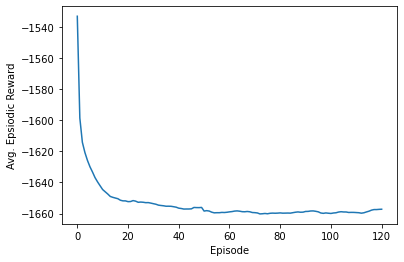

In [35]:
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()
